### Project Report
# Predicting Usage of a Video Game Research Server

By Victoria Zhou

## Introduction

Video games are a major part of modern entertainment and social interaction. As games grow more complex, understanding player behaviour helps improve design and infrastructure. Using data collected from the UBC Computer Science research group, I analyzed whether certain player traits can predict newsletter subscription.

My guiding question is: Can age, gender, experience, and played hours predict whether a player subscribes to the game-related newsletter?

I analyzed the following dataset with **individual player information.**

### Players Dataset Summary

| Variable Name | Variable Type | Description |
| --- | ----------- | -----------|
| experience | factor | Level of gameplay experience (Beginner, Amateur, Regular, Pro, Veteran).|
| subscribe | logical | Whether the player subscribed to the newsletter (TRUE or FALSE).|
| hashedEmail | character | Hashed email identifier (used to anonymize individual players).|
| played_hours | numeric | Total number of hours the player has spent on the server.|
| name | character | Player’s in-game display name (not used in analysis).|
| gender | factor | Player’s self-reported gender (Male, Female, Non-binary, Two-Spirited, Agender, Prefer not to say, Other).|
| Age | integer | Player’s age in years.|

**Summary Statistics & Key Insights**
- Number of observations: 196 players
- Number of variables: 7
- Source: Minecraft research server
- Collection Method: Player info collected at account registration, and gameplay time was recorded during server use.
- Subscription: 144 players subscribed (73%)
- Age: Mean = 20.5, Median = 19, Range = 8–50 
- Playtime: Mean = 5.85 hours
- Most common experience level: Amateur (63 players)
- Most common gender: Male (124 players)

**Observations & Issues**
- Missing values: Only in Age (2 cases)
- Limited behaviour tracking: No session or in-game activity metrics
- Sampling bias: Likely overrepresents younger users (median age = 19)

## Methods & Results

### Preliminary Exploratory Data Analysis

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### 1. Read and Tidy Data
For this project, I decided to use the variables age, experience, gender, played hours, and subscribe from the Minecraft player dataset.

To tidy and modify our data, I used the mutate and `as_factor` functions to convert character and logical types to factor types so that I could use them as categorical variables in the analysis. Then, I used the select function to create a data frame with only the columns I wanted to analyze.

In [2]:
#players <- read_csv("players.csv")
# to demonstrate that the dataset is readable from local into R
# I first downloaded the Minecraft player dataset provided by the UBC research group
# Then, I saved the file in my local directory for easy access
# Finally, I used read_csv to import the raw data into R for analysis
players <- read_csv("players.csv")
head(players)


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [3]:
players<-players|>
mutate(experience=as_factor(experience))|>
mutate(subscribe=as_factor(subscribe))|>
mutate(gender=as_factor(gender))|>
select(-hashedEmail,-name)
players

experience,subscribe,played_hours,gender,Age
<fct>,<fct>,<dbl>,<fct>,<dbl>
Pro,TRUE,30.3,Male,9
Veteran,TRUE,3.8,Male,17
Veteran,FALSE,0.0,Male,17
⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,0.0,Prefer not to say,17
Amateur,FALSE,2.3,Male,17
Pro,TRUE,0.2,Other,NA


### 2. Summarize Data
First, the `set.seed` function is used to ensure that results are reproducible.

Then, the data is split into 75% for training and 25% for testing using the initial_split function.

To summarize the training data, I counted the percentage of player who subscribed to the game-related newsletter using the `group_by` and `summarize` functions.

In [4]:
set.seed(123) # ensures replicability
players_split <- initial_split(players, prop = 0.75, strata = subscribe) 
players_training <- training(players_split)
players_testing <- testing(players_split)

In [5]:
glimpse(players_training)
glimpse(players_testing)

Rows: 147
Columns: 5
$ experience   <fct> Amateur, Amateur, Veteran, Amateur, Veteran, Beginner, Re…
$ subscribe    <fct> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, F…
$ played_hours <dbl> 0.0, 0.1, 0.0, 0.0, 1.4, 0.0, 0.0, 0.9, 0.0, 0.1, 0.2, 0.…
$ gender       <fct> Male, Female, Male, Prefer not to say, Prefer not to say,…
$ Age          <dbl> 22, 17, 23, 33, 25, 24, 23, 18, 42, 22, 37, 28, 23, 17, 1…
Rows: 49
Columns: 5
$ experience   <fct> Veteran, Veteran, Amateur, Amateur, Pro, Amateur, Regular…
$ subscribe    <fct> TRUE, FALSE, TRUE, FALSE, TRUE, TRUE, TRUE, FALSE, TRUE, …
$ played_hours <dbl> 3.8, 0.0, 0.7, 0.0, 0.0, 48.4, 0.3, 0.1, 0.6, 0.4, 5.6, 2…
$ gender       <fct> Male, Male, Female, Male, Male, Female, Male, Male, Male,…
$ Age          <dbl> 17, 17, 21, 21, 17, 17, 8, 18, 26, 20, 17, 11, 17, 15, 22…


In [6]:
cat("Table 1: Number and Percentage of Players that Subscribe to the Newsletter\n")
players_proportions <- players_training |>
                          group_by(subscribe) |>
                          summarize(count = n()) |>
                          mutate(percent = 100*count/nrow(players_training))
players_proportions

Table 1: Number and Percentage of Players that Subscribe to the Newsletter


subscribe,count,percent
<fct>,<int>,<dbl>
FALSE,39,26.53061
TRUE,108,73.46939


In [7]:
# Define a simple custom mode function
get_mode <- function(x) {
  uniq_vals <- unique(x)
  uniq_vals[which.max(tabulate(match(x, uniq_vals)))]
}

cat("Table 2: Average Predictor Values for Subscribers and Non-subscribers")
comparison <- players_training |>
                group_by(subscribe) |>
                summarize(avg_age = mean(Age, na.rm=TRUE),
                          avg_played_hours = mean(played_hours, na.rm=TRUE),
                          mode_experience = get_mode(experience),
                          mode_gender = get_mode(gender))
comparison

Table 2: Average Predictor Values for Subscribers and Non-subscribers

subscribe,avg_age,avg_played_hours,mode_experience,mode_gender
<fct>,<dbl>,<dbl>,<fct>,<fct>
FALSE,23.87179,0.4641026,Amateur,Male
TRUE,19.93396,9.7250000,Amateur,Male


### 3. Exploratory Data Visualization
I created separate visualizations for each predictor to explore its relationship with newsletter subscriptions. For age and played_hours, I used `geom_boxplot` to compare the distribution and central tendency of these continuous variables between subscribers and non-subscribers. Boxplots make it easy to identify differences in medians, variability, and the presence of outliers. For experience level and gender, I used `geom_bar` with position = "fill" to show the proportion of players in each category who subscribed. This approach is well-suited for visualizing how categorical variables relate to a binary outcome.

Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


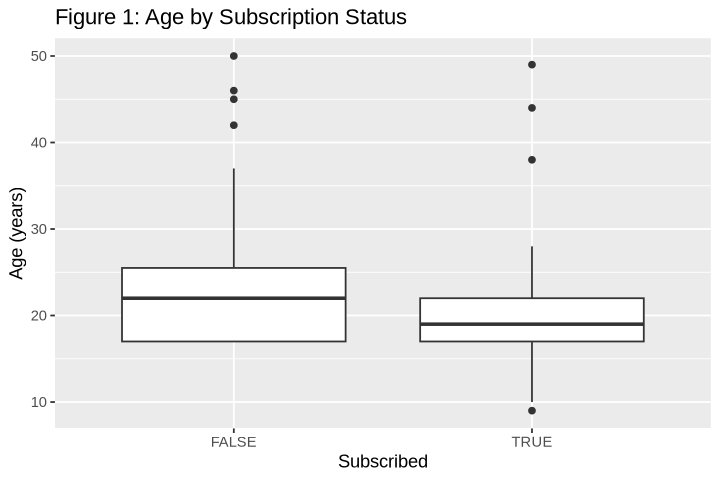

In [11]:
options(repr.plot.width = 6, repr.plot.height = 4)
age_plot<-ggplot(players_training, aes(x = subscribe, y = Age)) +
  geom_boxplot() +
  labs(title = "Figure 1: Age by Subscription Status", x = "Subscribed", y = "Age (years)")
age_plot

The boxplot shows that subscribers tend to be slightly older than non-subscribers and have a narrower age range. Non-subscribers show greater variability. While differences are modest, age may still offer some predictive value, with older players slightly more likely to subscribe.

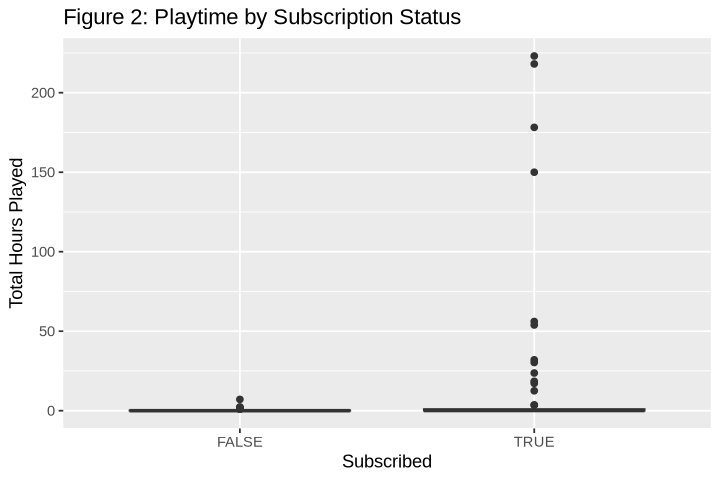

In [14]:
played_hours_plot<-ggplot(players_training, aes(x = subscribe, y = played_hours)) +
  geom_boxplot() +
  labs(title = "Figure 2: Playtime by Subscription Status", x = "Subscribed", y = "Total Hours Played")
played_hours_plot

Subscribers generally have higher total playtime, with more extreme high-hour outliers. This suggests a positive relationship between server engagement and subscription likelihood, making played_hours a potentially strong behavioral predictor.

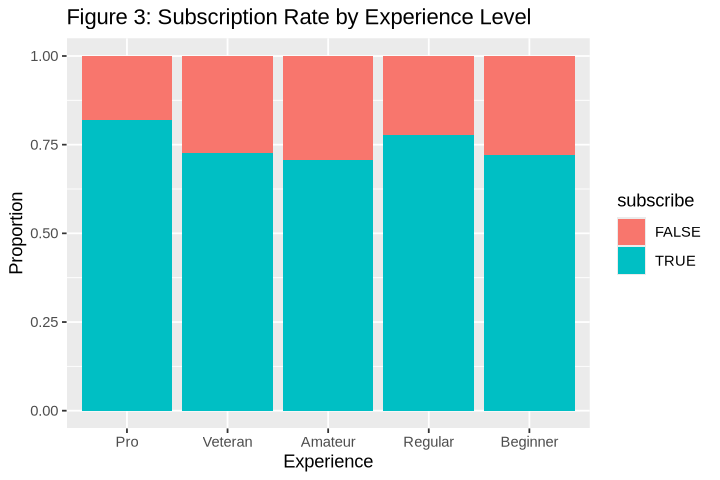

In [16]:
gender_plot<-ggplot(players_training, aes(x = experience, fill = subscribe)) +
  geom_bar(position = "fill") +
  labs(title = "Figure 3: Subscription Rate by Experience Level", x = "Experience", y = "Proportion")
gender_plot

Subscription rates vary by experience. Pro and Regular players show slightly higher proportions of subscribers, while Amateur and Veteran players are slightly lower. Though differences are small, experience level may contribute some predictive value.

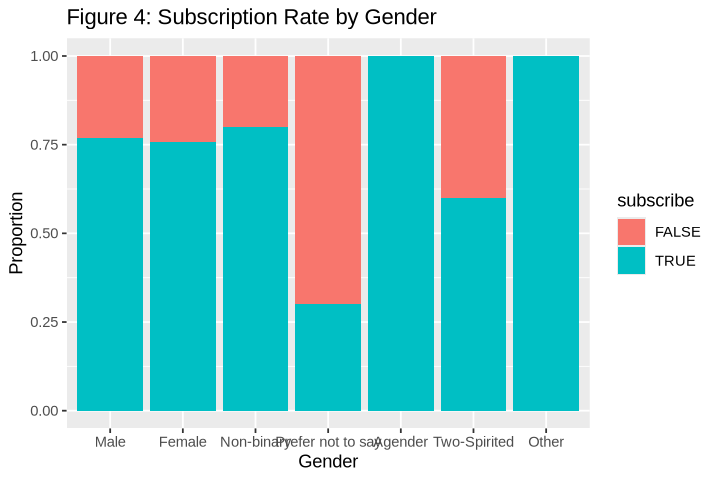

In [17]:
gender_plot<-ggplot(players_training, aes(x = gender, fill = subscribe)) +
  geom_bar(position = "fill") +
  labs(title = "Figure 4: Subscription Rate by Gender", x = "Gender", y = "Proportion")
gender_plot

Most gender groups show high subscription rates, particularly Non-binary, Two-Spirited, and Other. Players who selected "Prefer not to say" subscribed less often. Gender may have some predictive power, but small group sizes suggest caution in interpretation.

### 4. Data Analysis
To predict whether a player subscribes to the game-related newsletter, I used a k-nearest neighbours (KNN) classification model. KNN is appropriate for this task because the response variable (subscribe) is binary, and KNN can handle both categorical and continuous predictors after appropriate preprocessing.

**Why this method is appropriate:**
KNN is a simple, non-parametric model that makes predictions based on the most common outcome among a player's "nearest" neighbours in the dataset. This makes it effective for classification problems when the goal is to detect patterns or clusters in behaviour and characteristics.

**Assumptions:**
KNN assumes that similar observations are close in feature space, so predictors must be on comparable scales. It also assumes that local neighbourhoods are meaningful for predicting outcomes, which may not hold in sparse or noisy data.

**Limitations:**
KNN can be sensitive to irrelevant or correlated features, outliers, and the choice of k. It also becomes computationally expensive with larger datasets, although that is not a concern here. Scaling continuous variables like age and played hours is essential to avoid biasing distance calculations.

**Model selection and comparison:**
I used `initial_split()` to split the data into 75% training and 25% testing sets. I then applied `recipe()` to scale continuous variables (age and played hours) and one-hot encode categorical variables (gender and experience). I tuned the value of k using cross-validation on the training set to choose the value that minimized classification error.

**Data processing:**
All preprocessing (scaling and encoding) was done within the modeling pipeline using tidymodels. I applied a 5-fold cross-validation on the training set to select the best k, then evaluated the final model on the test set. This helped ensure the model generalizes well without overfitting.